## Replication of the European Commission Debt Sustainability Methodology

This notebook features an updated version of the methodology introduced in "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). For details on the methodology see Annex II, "Methodology and code for implementing the European Commission´s DSA in the context of the economic governance review".

Note that for the analysis to run, data on growth, ageing costs, property income, interest rate and inflation expectations, as well as institutional debt have to be added to "../data/InputData/deterministic_model_data.xlsx". These data have been sourced directly from the European Commission, the ESM, and Bloomberg, and we have no permission to share them publicly.

For comments and suggestions please contact lennard.welslau[at]bruegel[dot]org.

Last update: 21 December 2023

In [3]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from EcDsaModelClass import EcDsaModel
from EcStochasticModelClass import EcStochasticModel

# Import functions for analysis
from ec_dsa_functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tutorial
This section introduces some of the functionalities of the EcDsaModelClass and the EcStochasticModelClass.

### Initializing the DSA model and projecting the debt ratio

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "EcDsaModel" can be used, although I recommend always calling the EcStochasticModel class.

In [4]:
bel_dsa = EcDsaModel(country='BEL', adjustment_period=4)

Model functions (methods) and variables (attributes) can be inspected by typing the class name, followed by the attribute name. \
Explore the EcDsaModelClass and the EcStochasticModelClass python files to see which attributes and methods exist.

In [6]:
bel_dsa.ngdp

array([ 554.0443    ,  583.1735    ,  606.8791    ,  631.3539    ,
        656.09433528,  681.14967573,  705.79258459,  730.68306845,
        755.97339581,  781.10785599,  806.78489304,  834.23306012,
        863.3693073 ,  894.3032679 ,  927.03761274,  961.78191922,
        997.58709306, 1034.57697615, 1072.5728975 , 1111.80481845,
       1152.0791019 , 1193.40542676, 1235.79276005, 1279.3755197 ,
       1324.04354899, 1370.07424855, 1417.36154925, 1465.92532731,
       1515.78527031, 1566.96090895, 1619.63104783, 1673.66524493])

In [5]:
bel_dsa.ageing_cost

array([24.41146, 24.56619, 24.7434 , 24.75704, 25.01473, 25.19209,
       25.35499, 25.51885, 25.5575 , 25.72   , 25.84949, 25.99172,
       26.10518, 26.29145, 26.42218, 26.58337, 26.69289, 26.84103,
       26.92466, 27.0571 , 27.12789, 27.25907, 27.33299, 27.46982,
       27.54733, 27.6748 , 27.74077, 27.86299, 27.91755, 28.02501,
       28.06556, 28.15976])

We can project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [3]:
bel_dsa.project(spb_target=1.6, scenario='financial_stress')

For non-linear adjustment paths, for example due to an Excessive Deficit Procedure, we can specify initial and intermediate adjustment periods. \
All adjustment steps are saved in the "adjustment_steps" attribute. \
Instead of specifying initial adjustment period manually, we could call the "calculate_edp" method, which finds the number of periods in which, given the current SPB target, the minimum adjustment of 0.5% under the EDP is binding. The resulting length of the initial adjustment period is updated automatically. In cases where the entire adjustment period is needed to reach the 3% deficit targets, the adjustment step size is increased.

In [4]:
bel_dsa.project(spb_target=0.6, 
                initial_adjustment_period=2,
                initial_adjustment_step=0.5,
                intermediate_adjustment_period=0,
                intermediate_adjustment_step=0,
                scenario='main_adjustment')

In [5]:
bel_dsa.adjustment_steps

array([0.5   , 0.5   , 1.0041, 1.0041])

We can show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe. If the method is called without specified variables, it returns a dataframe with the structural primary balance, the overall balance, and the debt ratio. 

In [7]:
bel_dsa.df().iloc[1:7]

spb_bca     ob       d
t y                           
1 2023   -2.811 -4.693 106.276
2 2024   -2.408 -4.893 106.434
3 2025   -1.908 -4.707 107.405
4 2026   -1.408 -4.549 108.169
5 2027   -0.404 -4.029 108.756
6 2028    0.600 -3.397 108.631

If the df method is called with parameter "all" set to "True", a preset list of variables will be included. The variables are listed below.

In [8]:
bel_dsa.df(all=True).columns

Index(['spb_bca', 'ob', 'd', 'rg', 'rg_pot', 'ng', 'output_gap', 'pi',
       'rgdp_pot', 'rgdp', 'ngdp', 'i_st', 'i_lt', 'iir_lt', 'iir', 'sf',
       'ageing_cost', 'ageing_component', 'cyclical_component', 'pb',
       'pb_cyclical_adj', 'pb_cyclical_ageing_adj', 'D', 'D_lt_inst', 'D_st',
       'D_lt', 'amortization', 'amortization_lt', 'amortization_lt_inst'],
      dtype='object')

### Deterministic Optimization

The "find_spb_deterministic" optimizes for a structural primary balance at the end of the adjustment period that meets all specified criteria and scenario assumptions. It takes additional parameters, like initial adjustment periods, that have been specified in the initial projection as given.

In [9]:
bel_dsa.find_spb_deterministic(scenario='main_adjustment', criterion='deficit_reduction')

2.0495999999998307

The model projections are updated automatically to the optimal SPB target and we can plot the resulting debt ratio projection, for example by using the "df" method and pandas' built-in plotting function.

<Axes: title={'center': 'Belgium: Debt ratio and balance'}, xlabel='(t, Year)'>

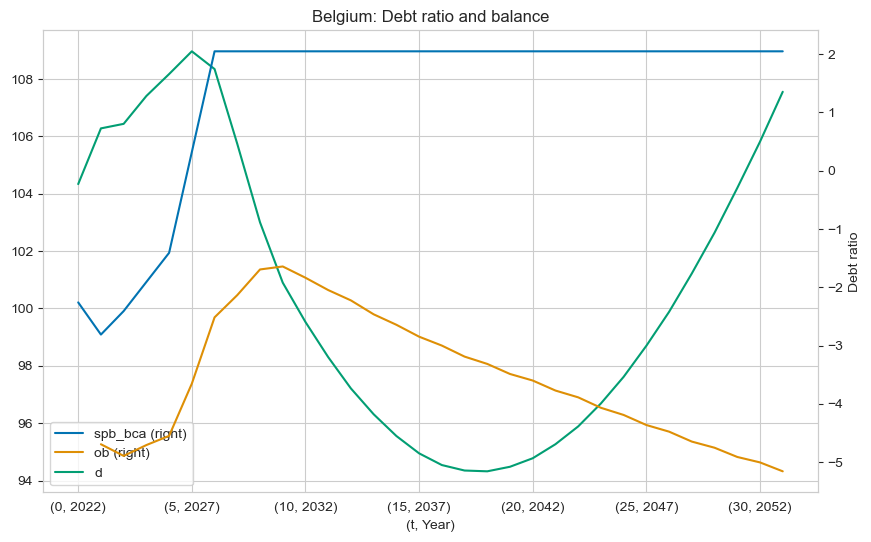

In [10]:
bel_dsa.df().plot(
    title='Belgium: Debt ratio and balance', 
    secondary_y=['spb_bca', 'ob'], 
    ylabel='Debt ratio', 
    xlabel='(t, Year)', 
    legend=True, 
    figsize=(10, 6))

### Stochastic Optimization

The Stochastic Model Class is a subclass of the EcDsaModels and inherits all its functionalities. It is initiated analogously.

In [14]:
esp_dsa = EcStochasticModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [15]:
esp_dsa.project()
esp_dsa.simulate(N=1000000)

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio.

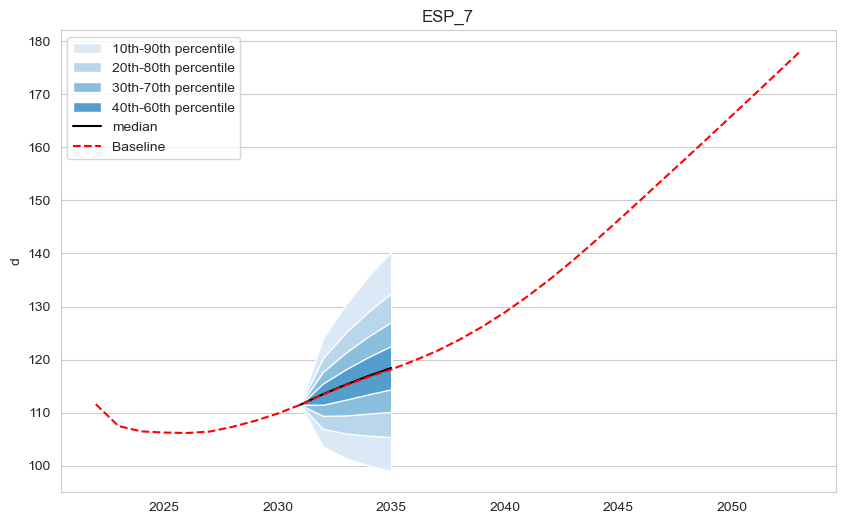

In [16]:
esp_dsa.fanchart(variable='d')

The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing.

In [17]:
esp_dsa.find_spb_stochastic(prob_target=0.3)

2.24687503871481

### Integrated optimization

To quickly calculate all scenarios and detmerine which is binding, we can call the "find_spb_binding" method. Note that this method is only available after initalizing a stochastic model. \
The method determines optimal SPB targets for all deterministic and stochastic DSA criteria, as well as for the 3% deficit criteria. It then checks whether either the EDP or either of the two safeguards, the debt and the deficit resilience safeguard, are violated and corrects the binding SPB target accordingly.

In [25]:
esp_dsa.find_spb_binding(save_df=True)


________________________ ESP 7-year adjustment ________________________
SPB*: 2.426799999999817 (adverse_r_g_debt_decline)
EDP not binding
SPB* after binding debt safeguard: 2.972599999999796
Deficit resilience safeguard not binding during adjustment period
Deficit resilience safeguard not binding after adjustment period


'Binding SPB target: 2.9725999999997956 (debt_safeguard)'

The "find_spb_binding" method saves a dictionaries with the binding targets and timeseries for all scenarios. In addition, it saves the projection parameters of the binding scenario for quick replication.

In [21]:
esp_dsa.spb_target_dict

{'main_adjustment_deficit_reduction': 1.955799999999833,
 'main_adjustment_debt_decline': 1.7115999999998333,
 'lower_spb_debt_decline': 2.1885999999998256,
 'financial_stress_debt_decline': 1.7120999999998332,
 'adverse_r_g_debt_decline': 2.4267999999998167,
 'stochastic_debt_decline': 2.204676017283409,
 'debt_safeguard': 2.972599999999796,
 'post_adjustment': 2.9725999999997956,
 'binding': 2.9725999999997956}

In [29]:
esp_dsa.df_dict['binding'].head()

spb_bca     ob       d    rg  rg_pot     ng  output_gap    pi  \
t y                                                                     
0 2022   -2.329    NaN 111.618 5.452   1.192 10.152       0.042 4.142   
1 2023   -2.073 -3.923 107.509 2.365   1.672  7.744       0.724 5.255   
2 2024   -0.981 -3.153 106.495 1.661   1.827  5.082       0.559 3.366   
3 2025   -0.416 -2.852 106.410 1.616   2.000  3.632       0.181 1.983   
4 2026    0.149 -2.830 105.911 1.162   1.696  3.233      -0.345 2.047   

        rgdp_pot      rgdp  ...     pb  pb_cyclical_adj  \
t y                         ...                           
0 2022 1,192.450 1,192.948  ... -2.371              NaN   
1 2023 1,212.393 1,221.167  ... -1.641              NaN   
2 2024 1,234.538 1,241.445  ... -0.647              NaN   
3 2025 1,259.231 1,261.511  ... -0.310           -0.310   
4 2026 1,280.585 1,276.164  ... -0.061           -0.061   

        pb_cyclical_ageing_adj         D  D_lt_inst    D_st      D_lt  \
t y                                                                     
0 2022                     NaN 1,502.804     40.157  76.430 1,426.374   
1 2023                     NaN 1,557.720     36.515 100.885 1,456.834   
2 2024                     NaN 1,621.487     28.297 105.015 1,516.472   
3 2025                     NaN 1,679.069     19.146 108.745 1,570.324   
4 2026                     NaN 1,725.216     10.928 111.733 1,613.482   

        amortization  amortization_lt  amortization_lt_inst  
t y                                                          
0 2022           NaN              NaN                 0.000  
1 2023       214.900          138.470                 3.643  
2 2024       245.850          144.964                 8.218  
3 2025       255.511          150.495                 9.150  
4 2026       262.292          153.547                 8.218  

[5 rows x 29 columns]

In [28]:
esp_dsa.binding_parameter_dict

{'binding_spb_target': 2.972599999999796,
 'initial_adjustment_period': 0,
 'initial_adjustment_step': 0.5,
 'intermediate_adjustment_period': 0,
 'intermediate_adjustment_step': 0,
 'deficit_resilience_periods': array([False, False, False, False, False, False, False]),
 'deficit_resilience_step': 0.25,
 'post_adjustment_periods': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False])}

The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
We can either call it directly by specifying an adjustment path or call it after we have optimized the path as above.

Text(0.5, 1.0, 'Probability of deficit during 7-year adjustment Spain')

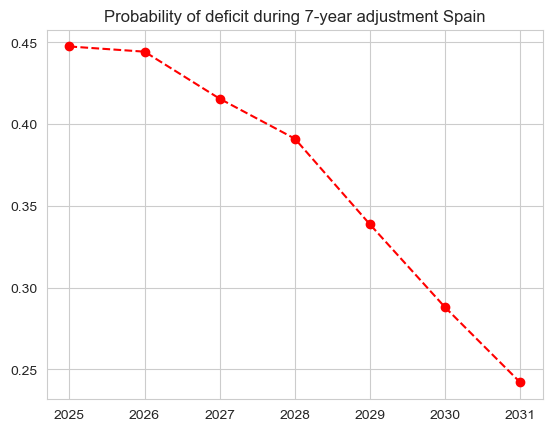

In [30]:
prob_deficit = esp_dsa.find_deficit_prob()
plt.plot(np.arange(2025, 2032), prob_deficit, marker='o', linestyle='--', color='red')
plt.title('Spain: Probability of deficit during 7-year adjustment')

## Analysis

### Set parameters and functions

In [31]:
# List of EU codes and countries for loop and chart titles
country_code_dict = {
    'AUT': 'Austria',
    'BEL': 'Belgium',
    'CYP': 'Cyprus',
    'CZE': 'Czech Republic',
    'DEU': 'Germany',
    'DNK': 'Denmark',
    'ESP': 'Spain',
    'EST': 'Estonia',
    'FIN': 'Finland',
    'FRA': 'France',
    'GRC': 'Greece',
    'HRV': 'Croatia',
    'HUN': 'Hungary',
    'IRL': 'Ireland',
    'ITA': 'Italy',
    'NLD': 'Netherlands',
    'POL': 'Poland',
    'PRT': 'Portugal',
    'ROU': 'Romania',
    'SVK': 'Slovakia',
    'SVN': 'Slovenia',
    'SWE': 'Sweden',
    'BGR': 'Bulgaria',
    'MLT': 'Malta',
    'LUX': 'Luxembourg',
    'LTU': 'Lithuania',
    'LVA': 'Latvia'
    }
country_codes = list(country_code_dict.keys())

In [32]:
# Initialize results dictionary
results_dict = {}
for country in country_codes:
    results_dict[country] = {}
    for adjustment_period in [4, 7]:
        results_dict[country][adjustment_period] = {}

In [33]:
# Set output path and create folders if they don't exist
today = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
if not os.path.exists(f'../output/{today}'):
    os.makedirs(f'../output/{today}')
if not os.path.exists(f'../output/{today}/fancharts'):
    os.makedirs(f'../output/{today}/fancharts') 
if not os.path.exists(f'../output/{today}/results_charts'):
    os.makedirs(f'../output/{today}/results_charts')       
output_path = f'../output/{today}'

In [73]:
# # Or read an existing results dict from pickle in output folder 
# today = '2023-12-21_16-00'
# output_path = output_path = f'../output/{today}'
# results_dict = pd.read_pickle(f'{output_path}/ec_dsa_results_dict_{today}.pkl')

In [40]:
# Call functions to run DSA and save results
run_dsa(country_codes=country_codes, results_dict=results_dict, output_path=output_path, today=today)
save_results(results_dict=results_dict, output_path=output_path, today=today)


--> 1 of 27, estimated remaining time: 0.0 minutes

________________________ AUT 4-year adjustment ________________________
SPB*: 1.1163999999998322 (adverse_r_g_debt_decline)
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
Deficit resilience safeguard not binding after adjustment period

________________________ AUT 7-year adjustment ________________________
SPB*: 1.1974663139521102 (stochastic_debt_decline)
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
Deficit resilience safeguard not binding after adjustment period

--> 2 of 27, estimated remaining time: 5.2 minutes

________________________ BEL 4-year adjustment ________________________
SPB*: 2.36799999999982 (adverse_r_g_debt_decline)
EDP already satisfied, deficit below 3% in period 3
Deficit resilience safeguard not binding during adjustment period
Deficit resilience safeguard not binding after adjustment 

### Tests

In [41]:
dsa = EcStochasticModel(country='FRA', adjustment_period=7)
dsa.find_spb_binding(edp=True, debt_safeguard=True, deficit_resilience=True)


________________________ FRA 7-year adjustment ________________________
SPB*: 0.7285999999998316 (main_adjustment_deficit_reduction)
SPB* after binding EDP: 0.6910999999998325, EDP period: 6
SPB* after deficit resilience: 0.8519999999999999, Deficit resilience periods: [2031]
SPB post-adjustment: 2.352, Post adjustment periods: [2032 2033 2034 2035 2036 2037]


'Binding SPB target: 0.8519999999999999 (main_adjustment_deficit_reduction)'

spb_bca     ob     sb       d  spb_adj  d_adj  interest_ratio
t  y                                                                  
1  2023   -3.022 -4.574 -4.512 109.627      NaN    NaN           0.015
2  2024   -2.422 -4.421 -4.399 109.485    0.600 -0.142           0.020
3  2025   -1.918 -4.276 -4.212 110.396    0.504  0.911           0.023
4  2026   -1.414 -4.224 -3.920 111.923    0.504  1.527           0.025
5  2027   -0.910 -4.034 -3.621 113.165    0.504  1.242           0.027
6  2028   -0.406 -3.688 -3.305 113.852    0.504  0.687           0.029
7  2029    0.098 -3.353 -2.970 114.143    0.504  0.291           0.031
8  2030    0.602 -3.000 -2.616 114.044    0.504 -0.099           0.032
9  2031    0.852 -2.755 -2.491 113.449    0.250 -0.595           0.033
10 2032    1.102 -2.569 -2.352 112.690    0.250 -0.759           0.035
11 2033    1.352 -2.381 -2.193 111.472    0.250 -1.217           0.035
12 2034    1.602 -2.213 -2.003 109.907    0.250 -1.566           0.036
13 2035    1.852 -1.979 -1.778 107.883    0.250 -2.024           0.036
14 2036    2.102 -1.709 -1.530 105.585    0.250 -2.298           0.036
15 2037    2.352 -1.444 -1.258 103.011    0.250 -2.573           0.036
16 2038    2.352 -1.266 -1.212 100.167    0.000 -2.844           0.036
17 2039    2.352 -1.118 -1.155  97.344    0.000 -2.824           0.035
18 2040    2.352 -0.995 -1.092  94.580    0.000 -2.763           0.034
19 2041    2.352 -0.864 -1.022  91.844    0.000 -2.737           0.034

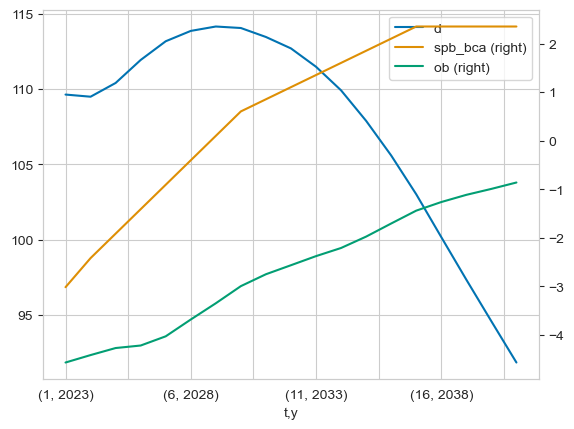

In [42]:
df = dsa.df('spb_bca', 'ob', 'sb', 'd', 'ngdp', 'interest').iloc[1:20]
df[['spb_adj', 'd_adj']] = df[['spb_bca', 'd']].diff()
df['interest_ratio'] = df['interest'] / df['ngdp']
df.drop(columns=['interest', 'ngdp'], inplace=True)
df.plot(y=['d', 'spb_bca', 'ob'], secondary_y=['spb_bca', 'ob'])
df

### Plot binding scenario charts

Error: CYP_4
Error: CYP_7
Error: GRC_4
Error: GRC_7
Error: HRV_4
Error: HRV_7
Error: ITA_4
Error: ITA_7
Error: BGR_4
Error: BGR_7


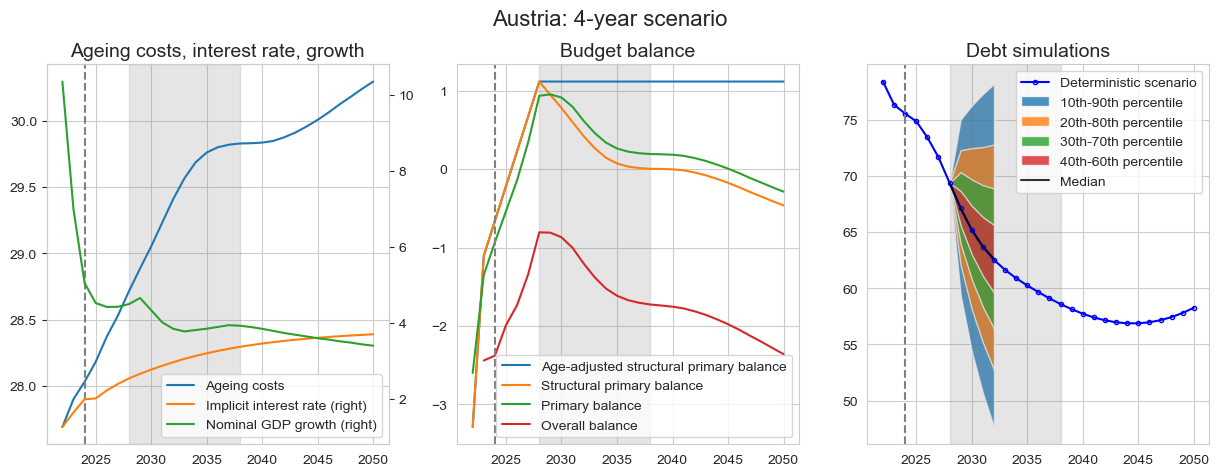

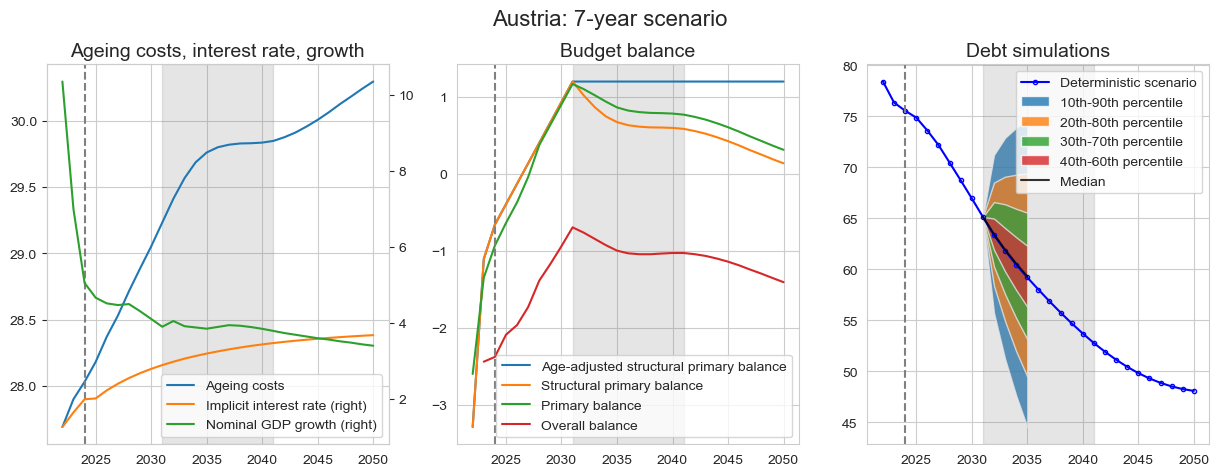

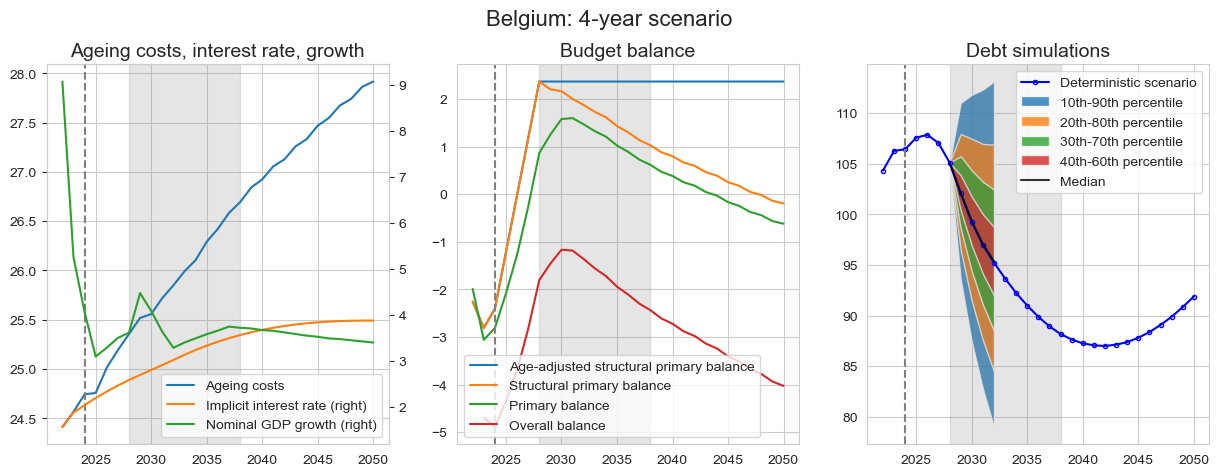

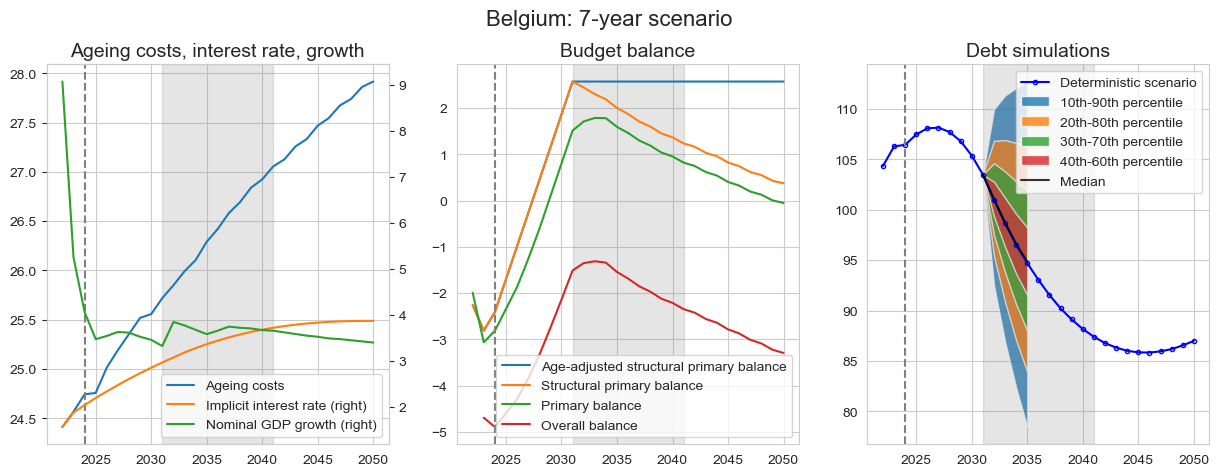

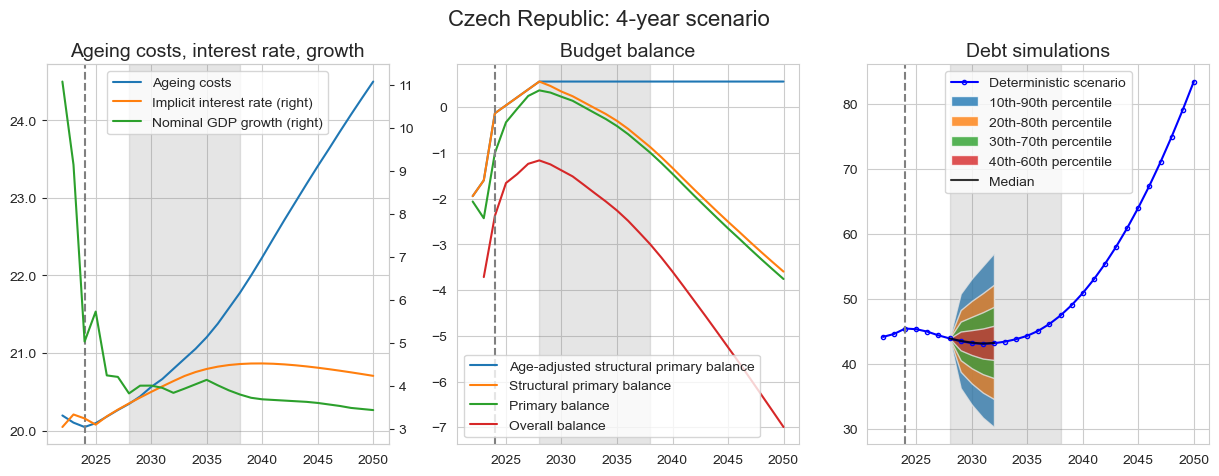

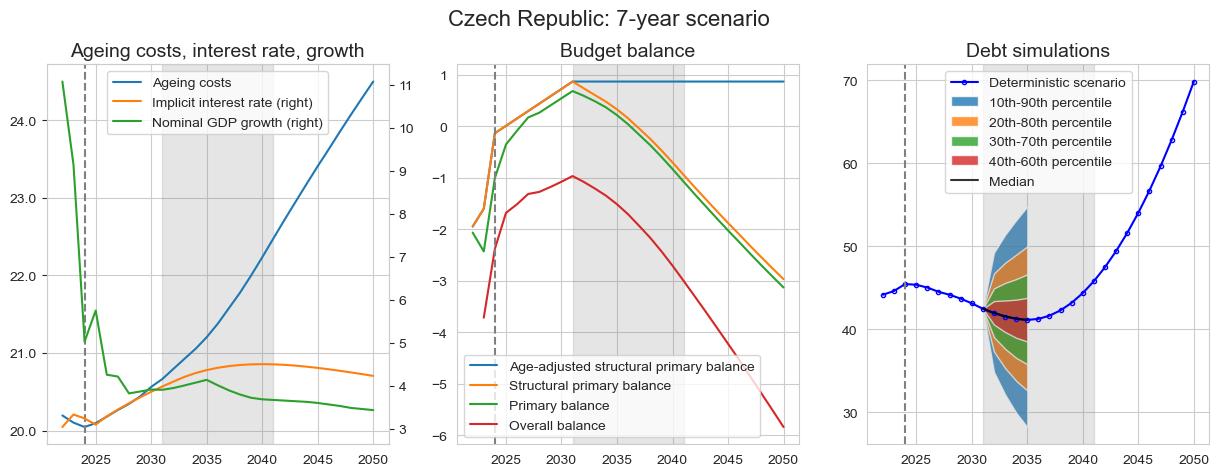

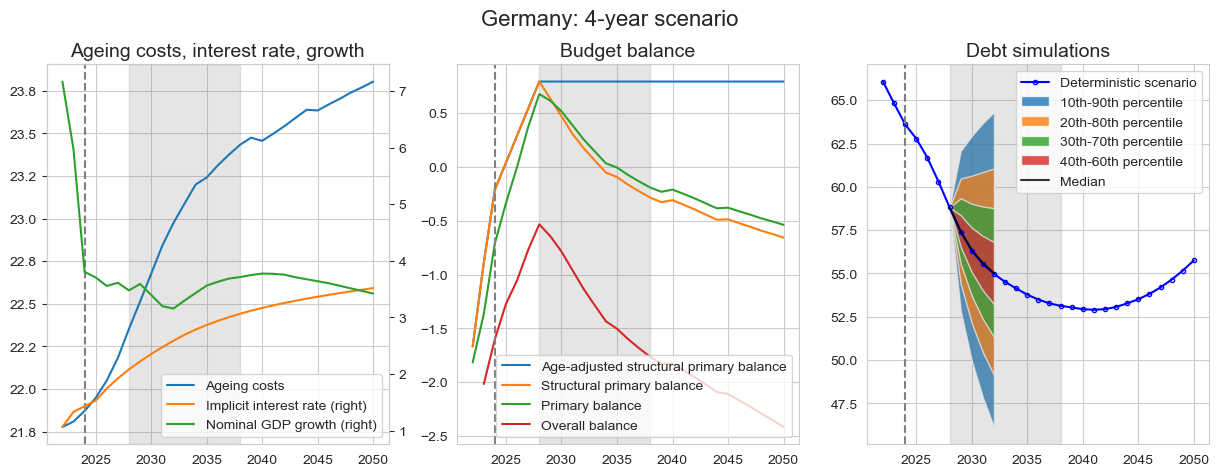

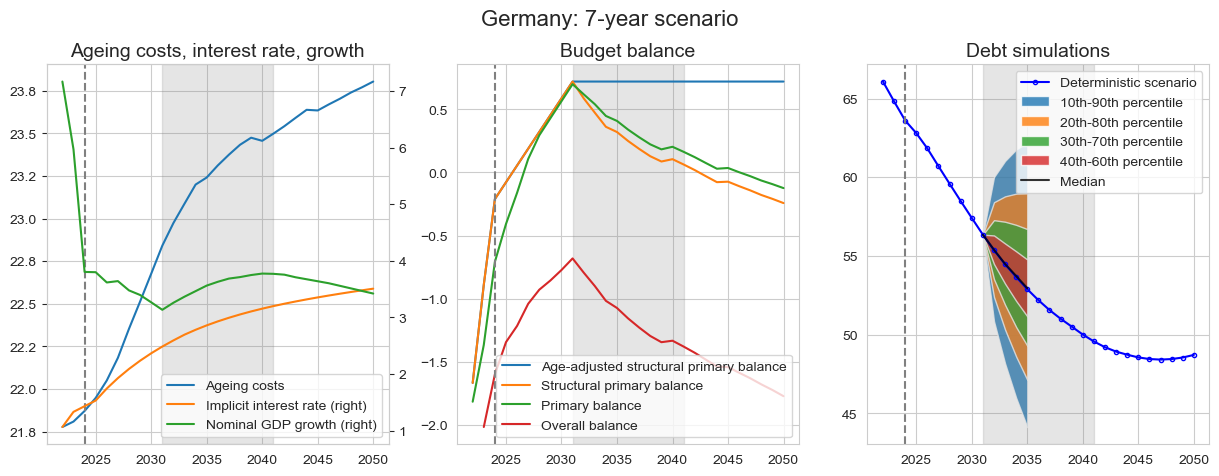

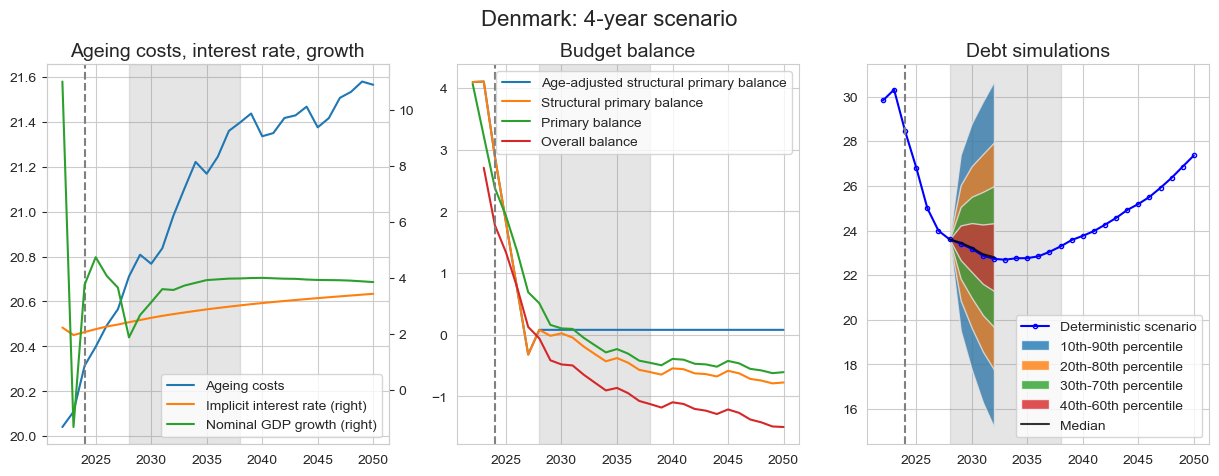

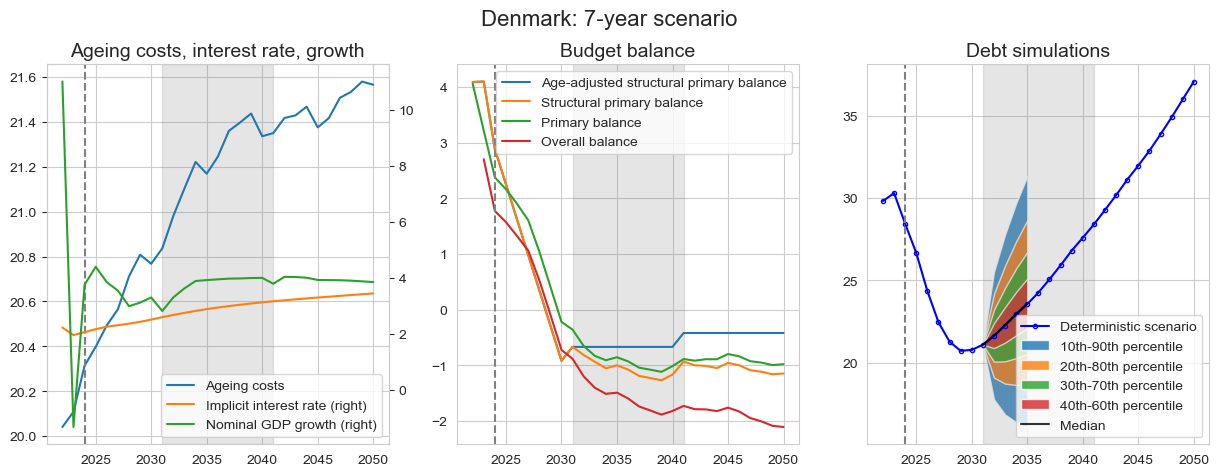

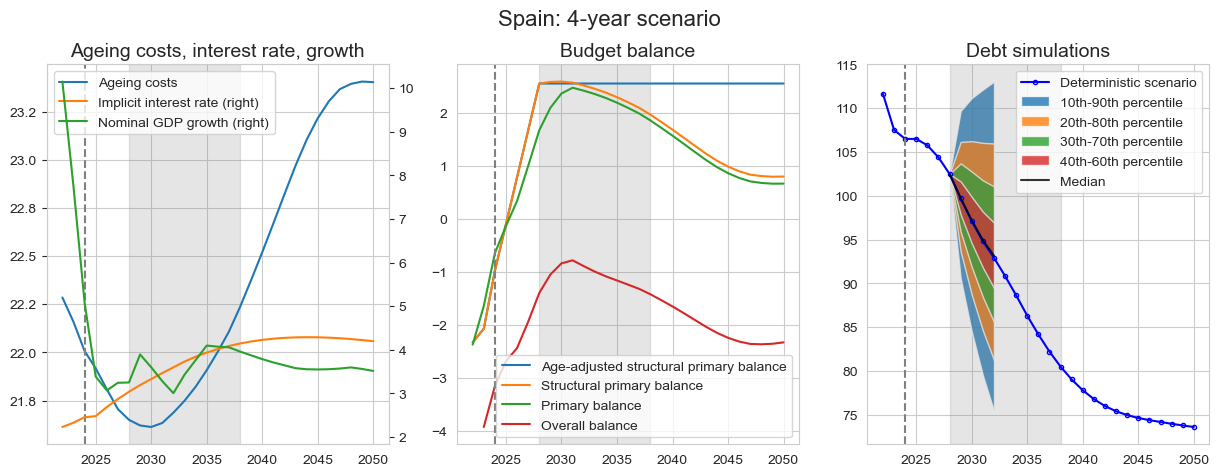

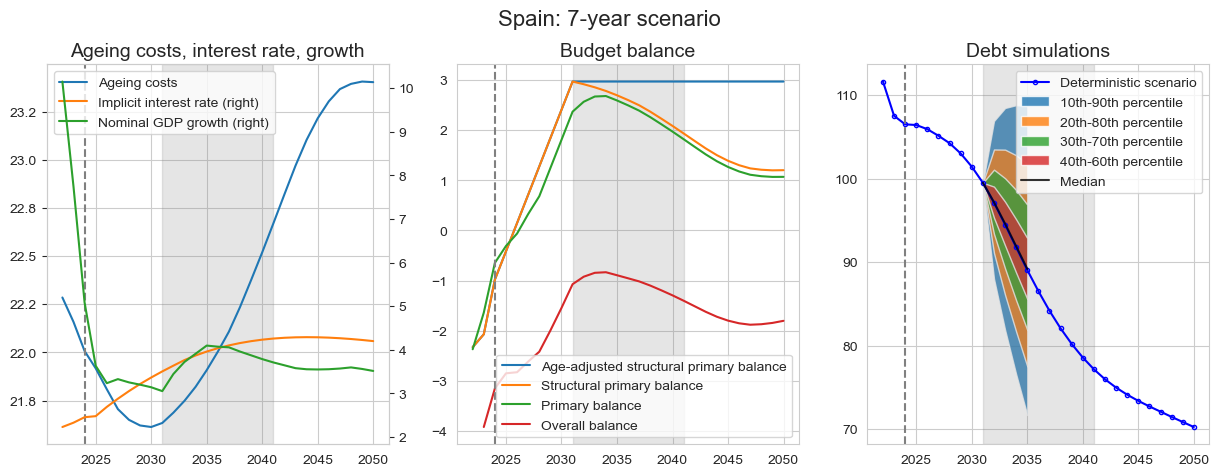

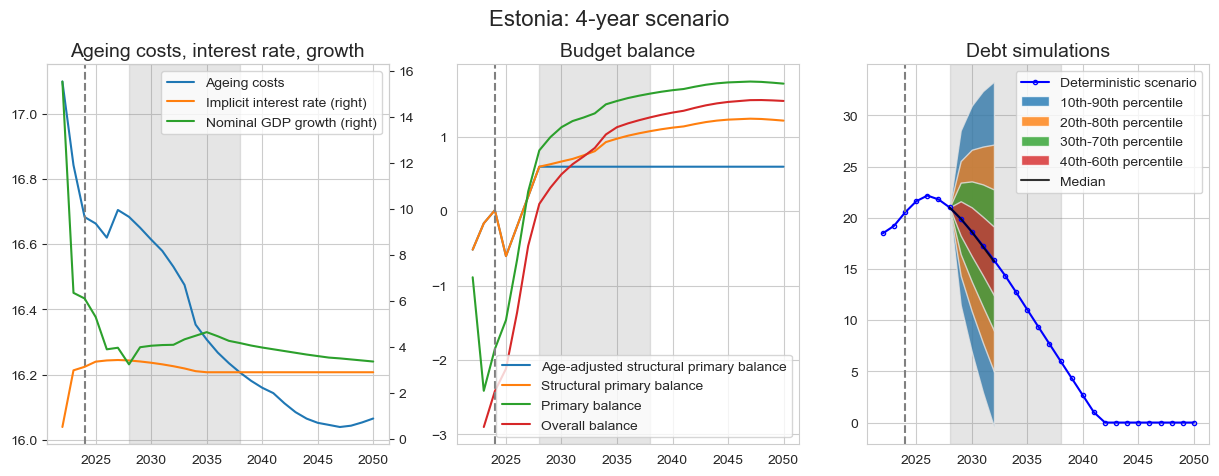

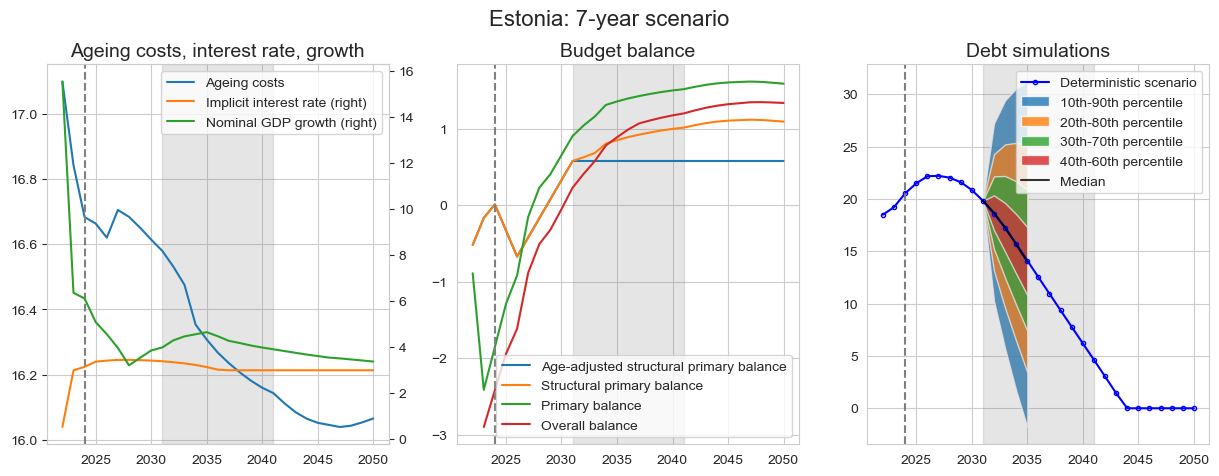

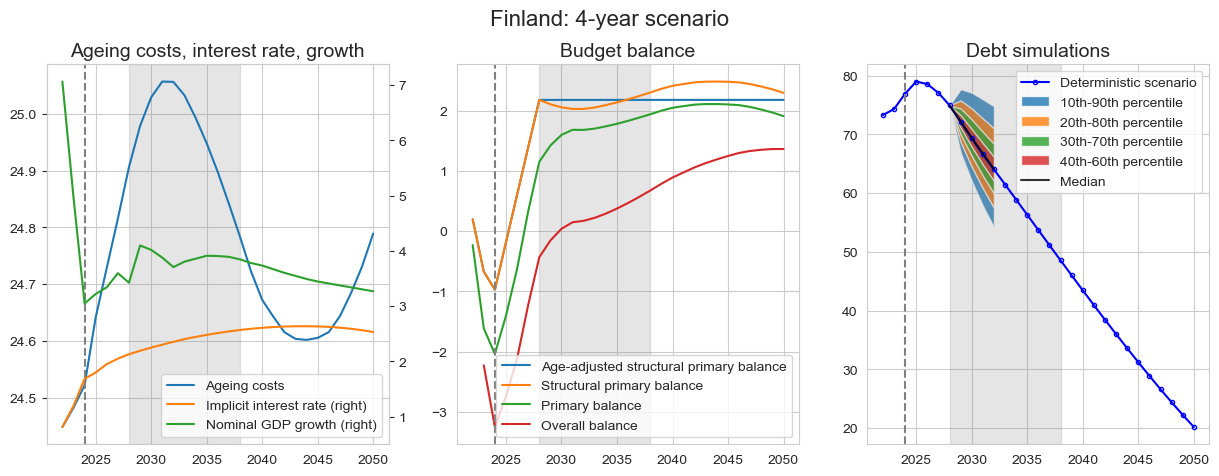

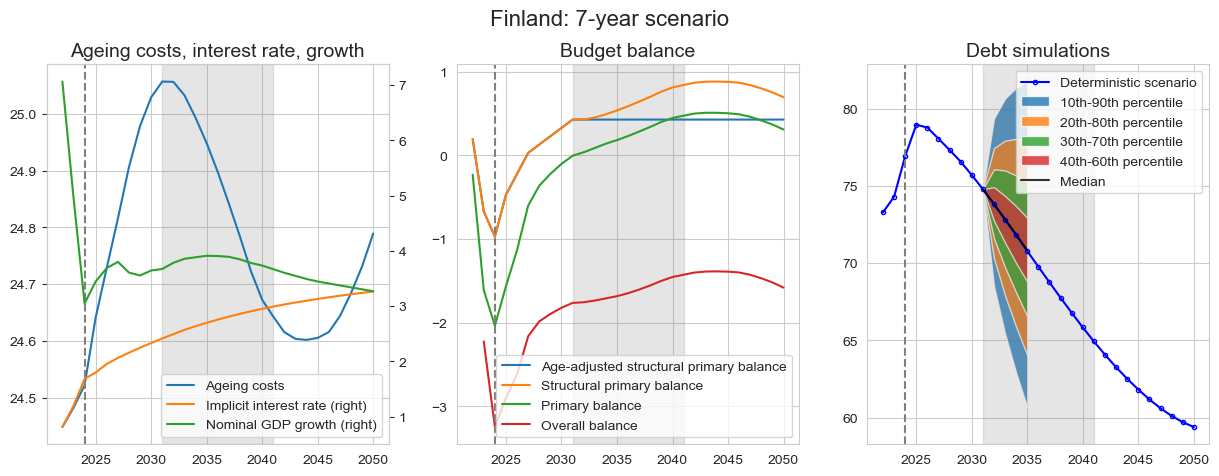

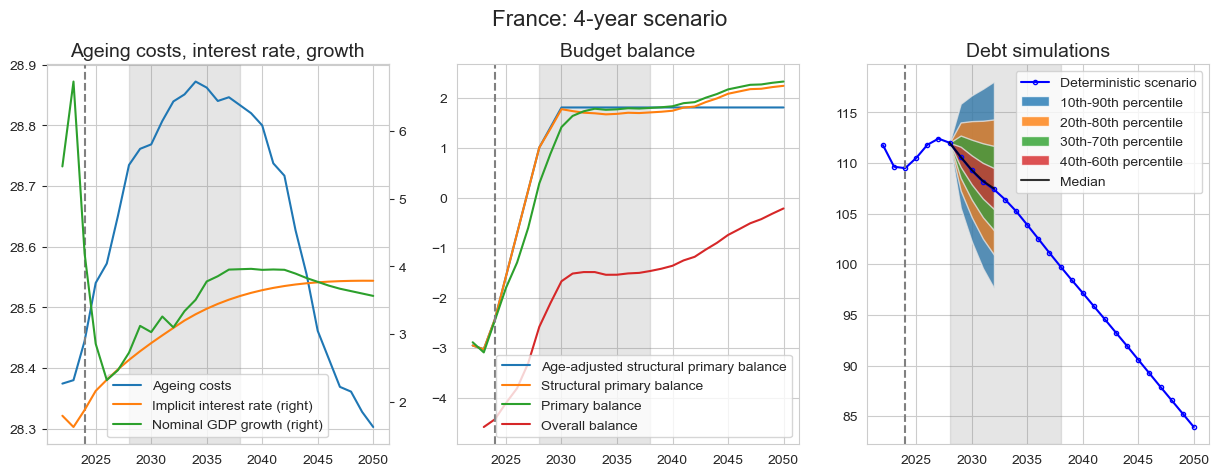

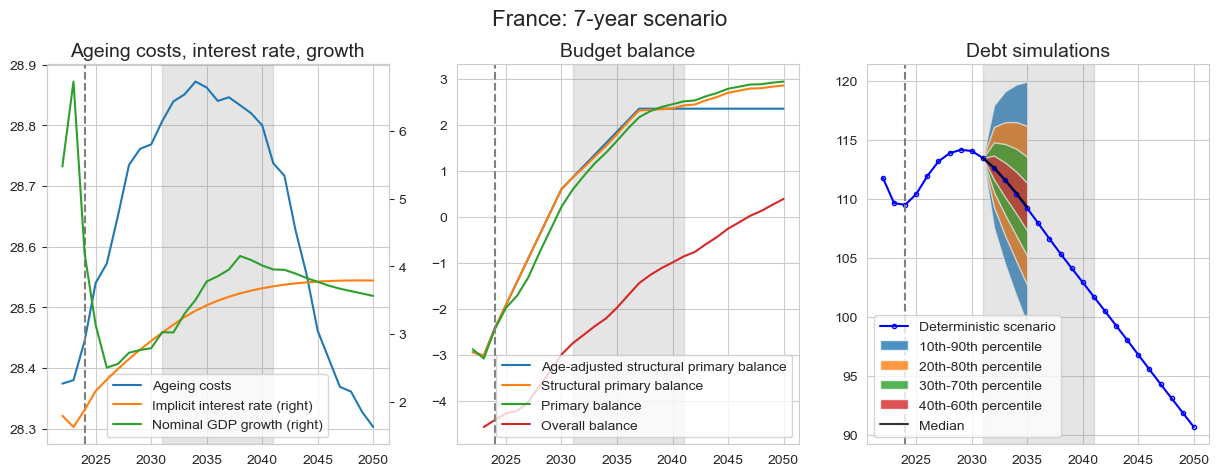

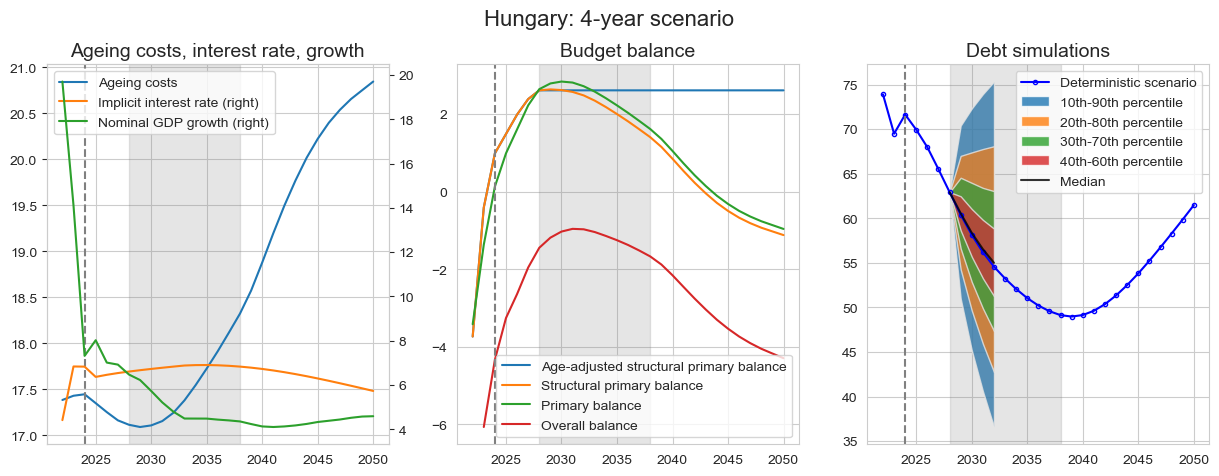

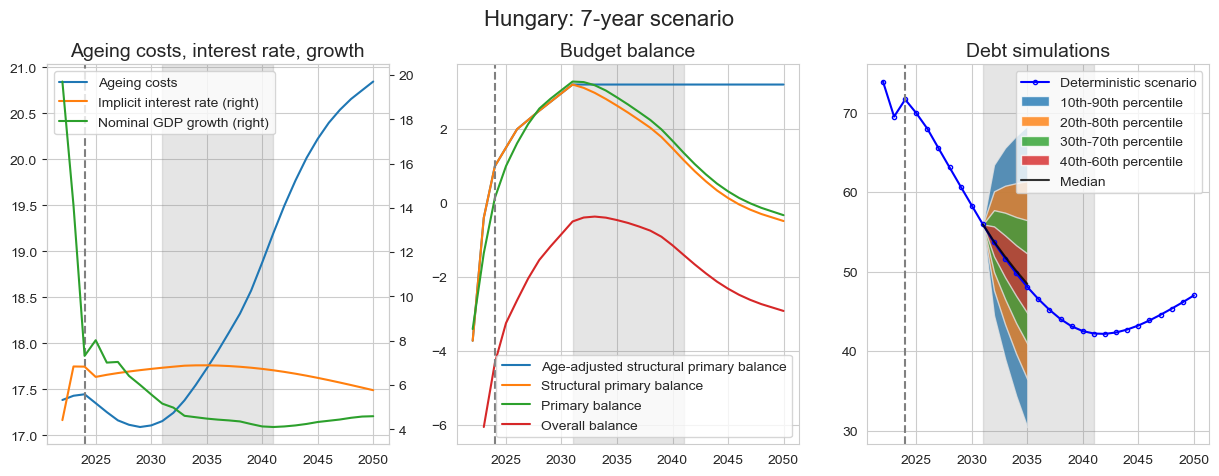

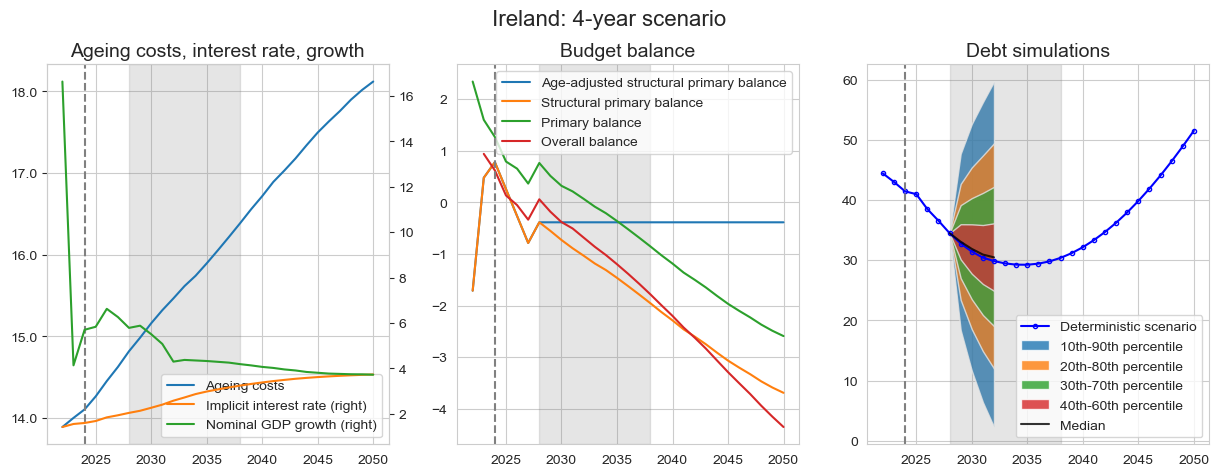

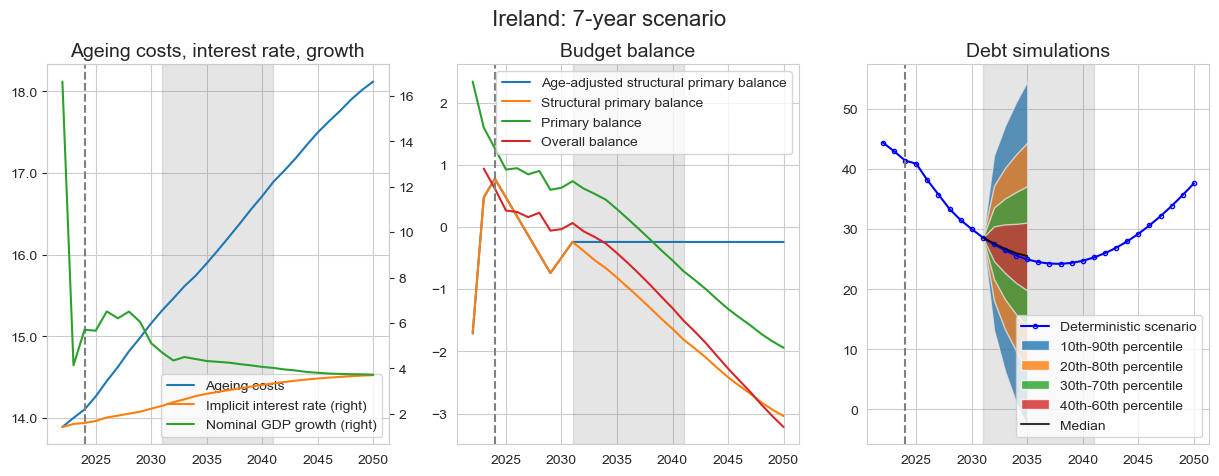

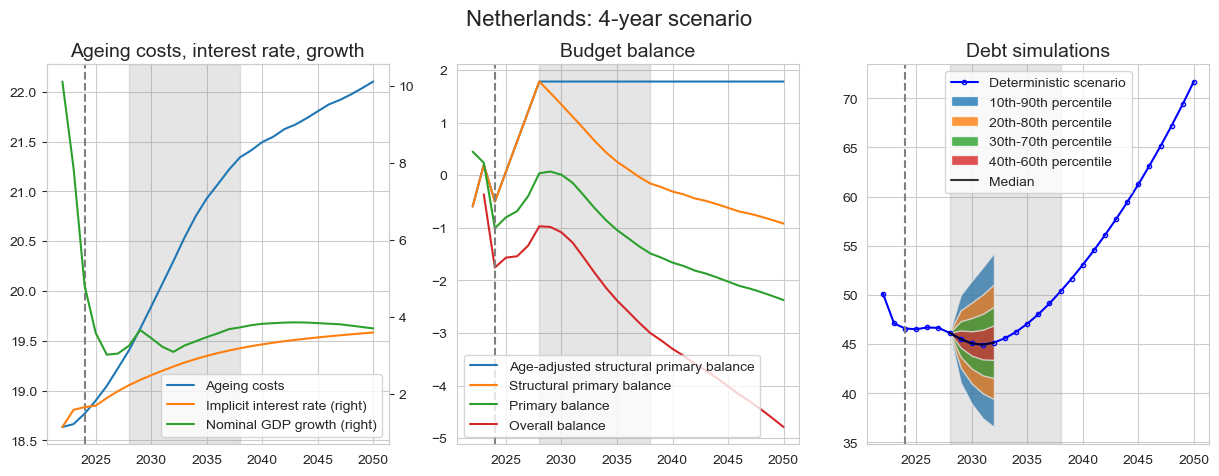

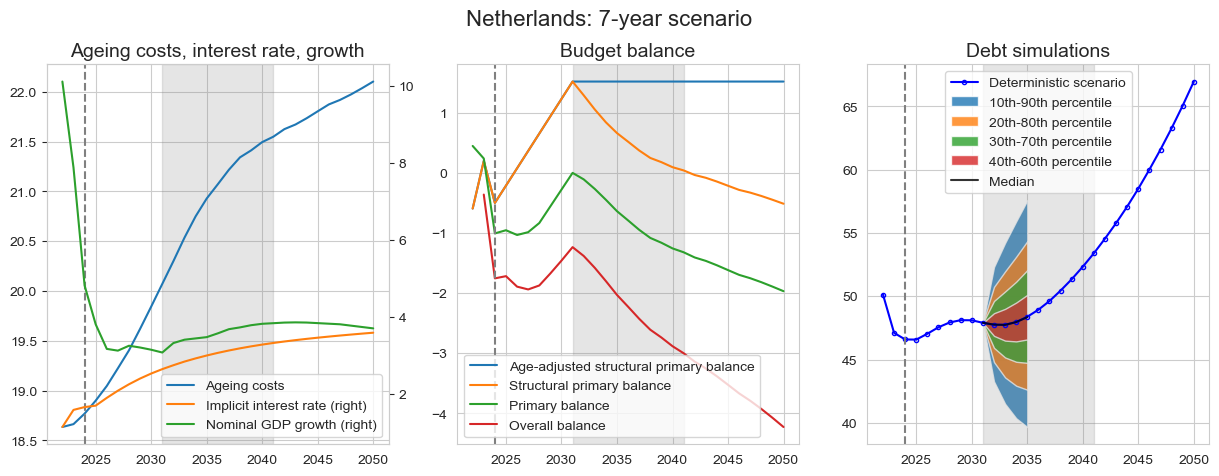

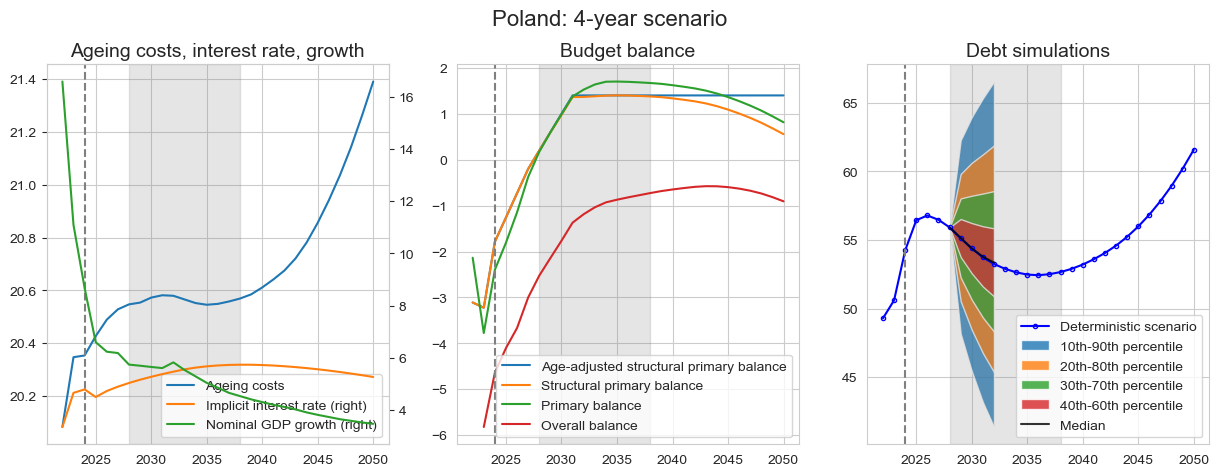

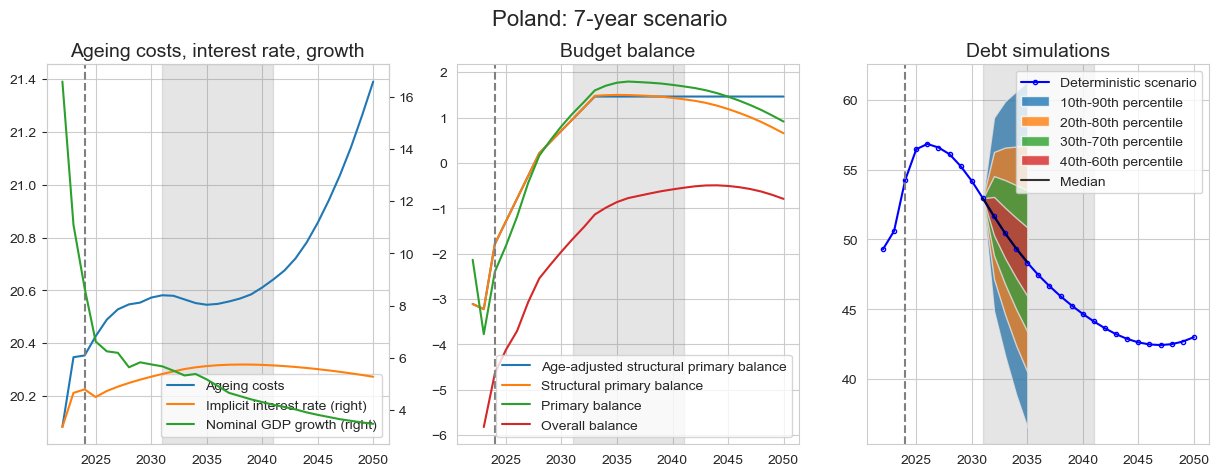

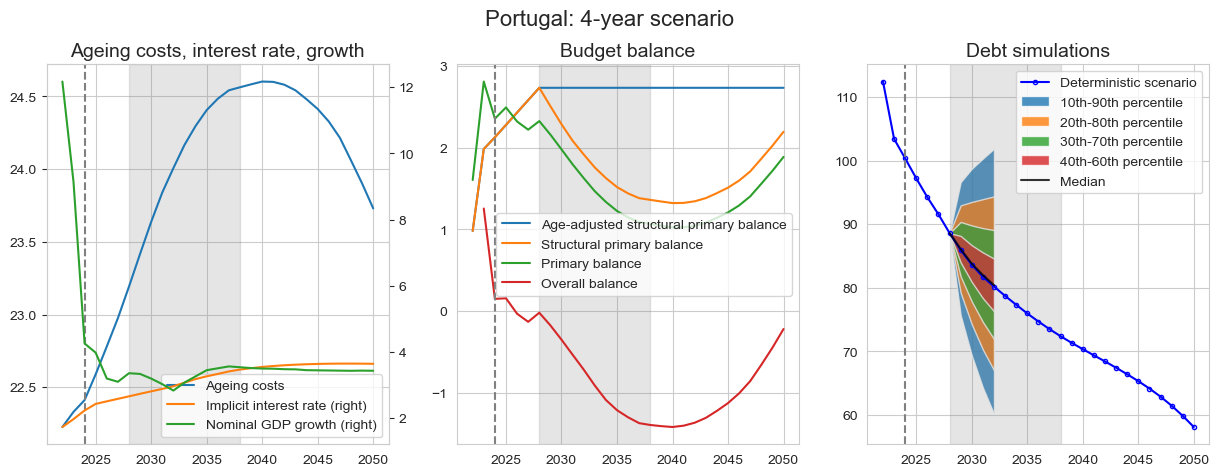

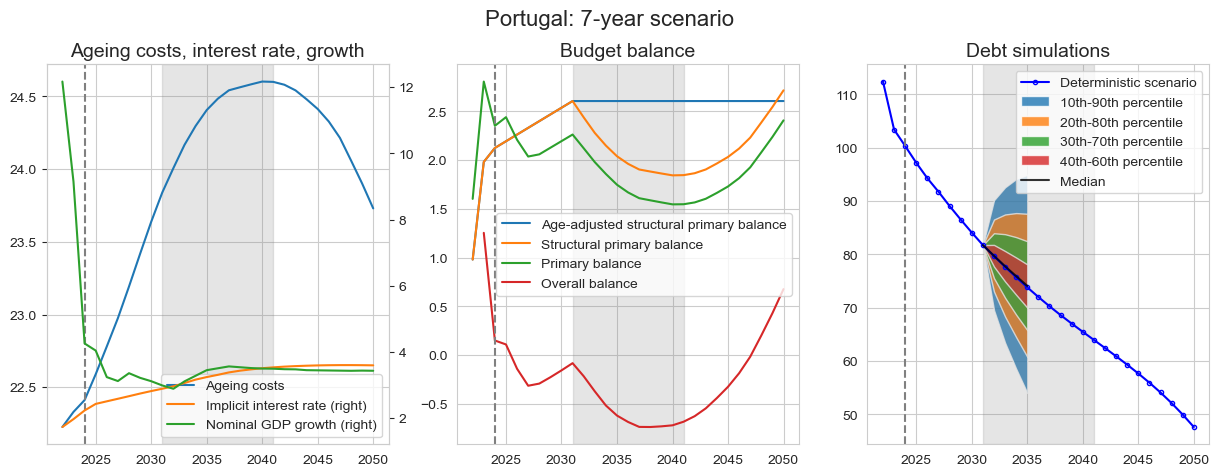

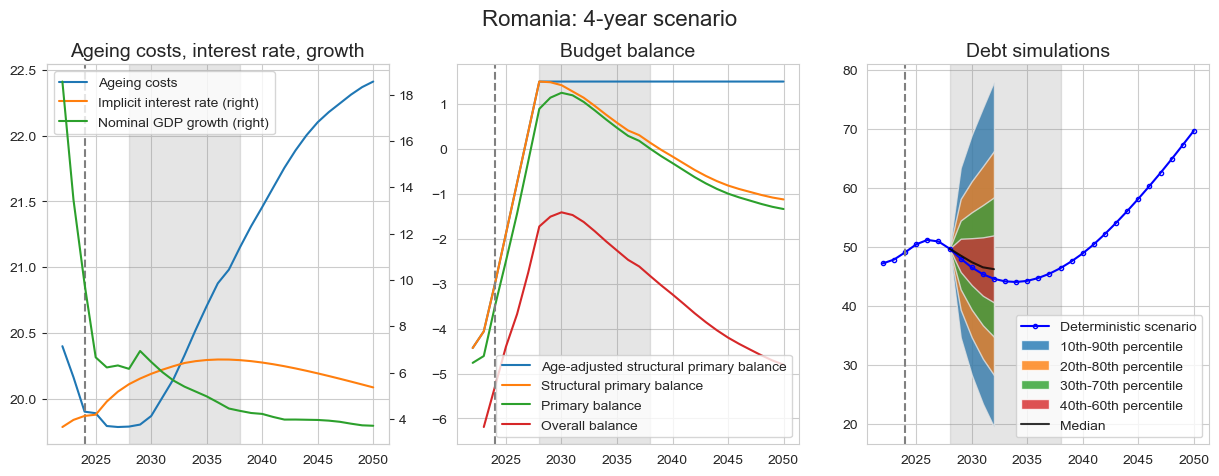

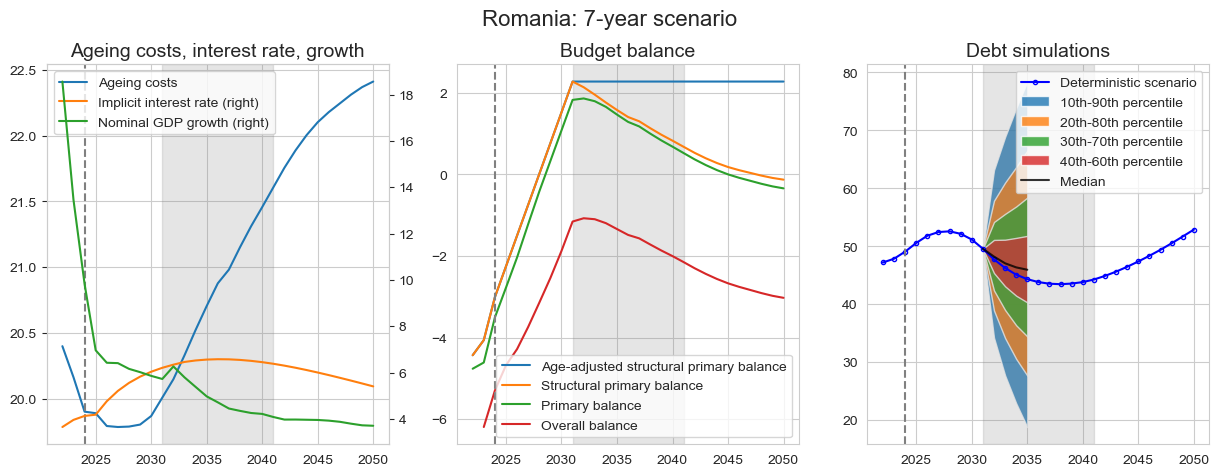

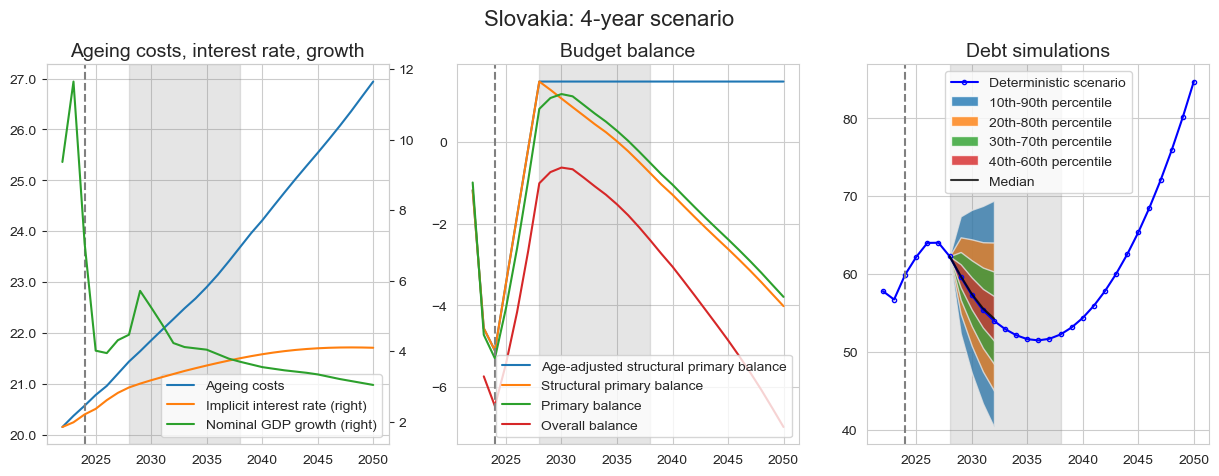

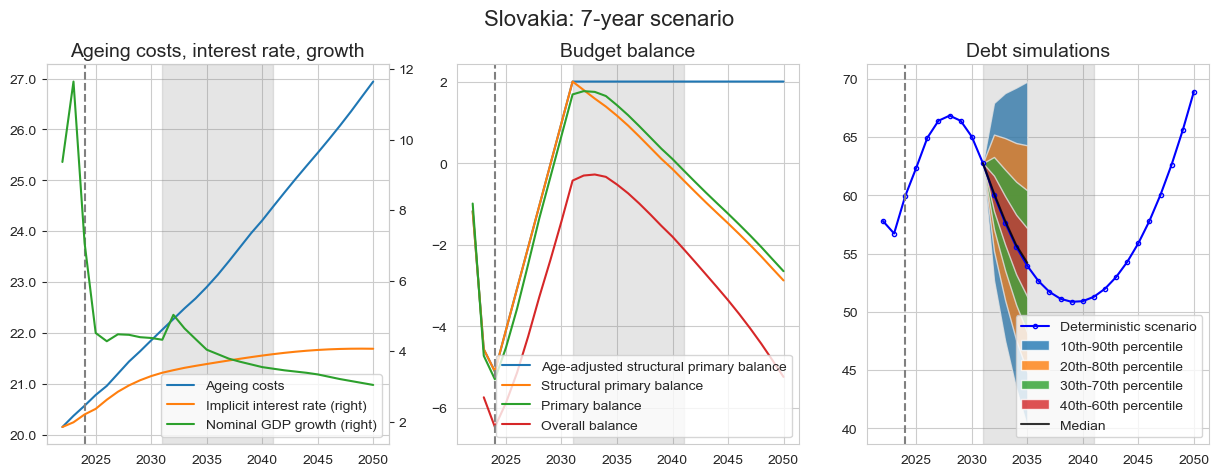

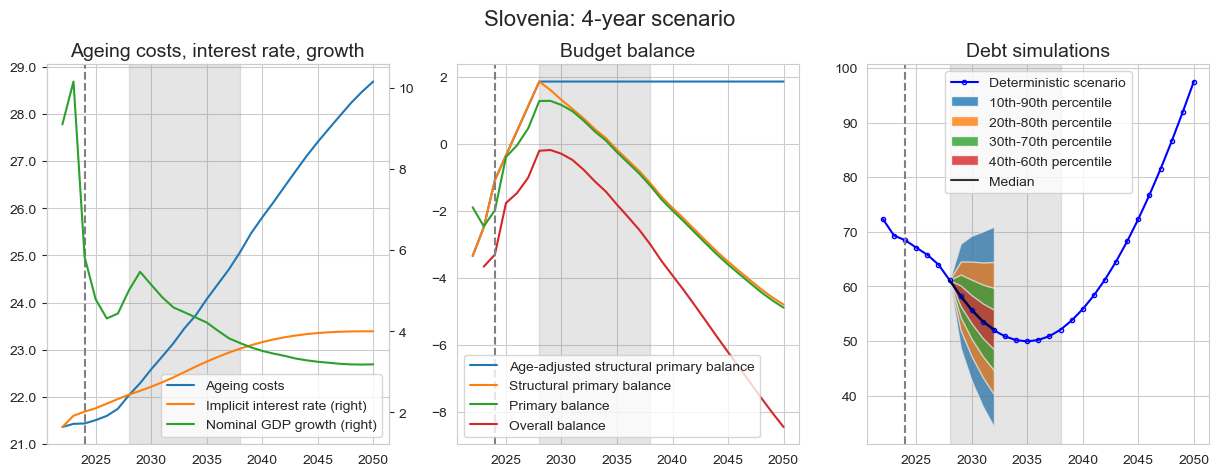

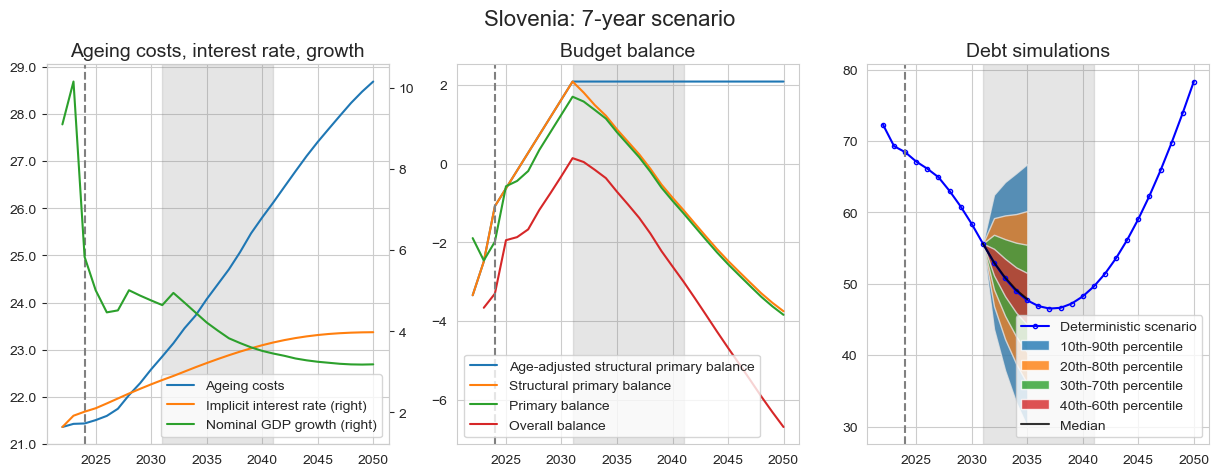

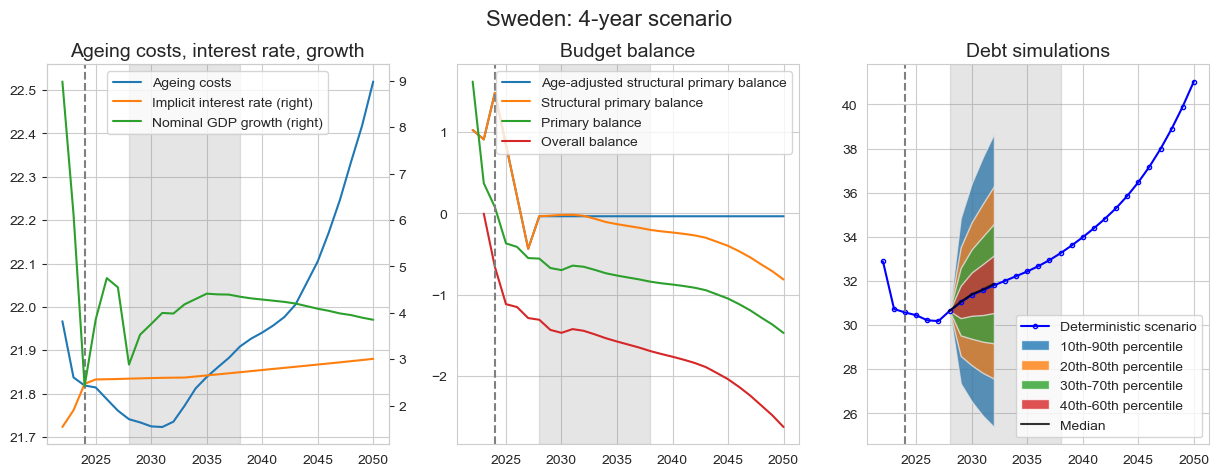

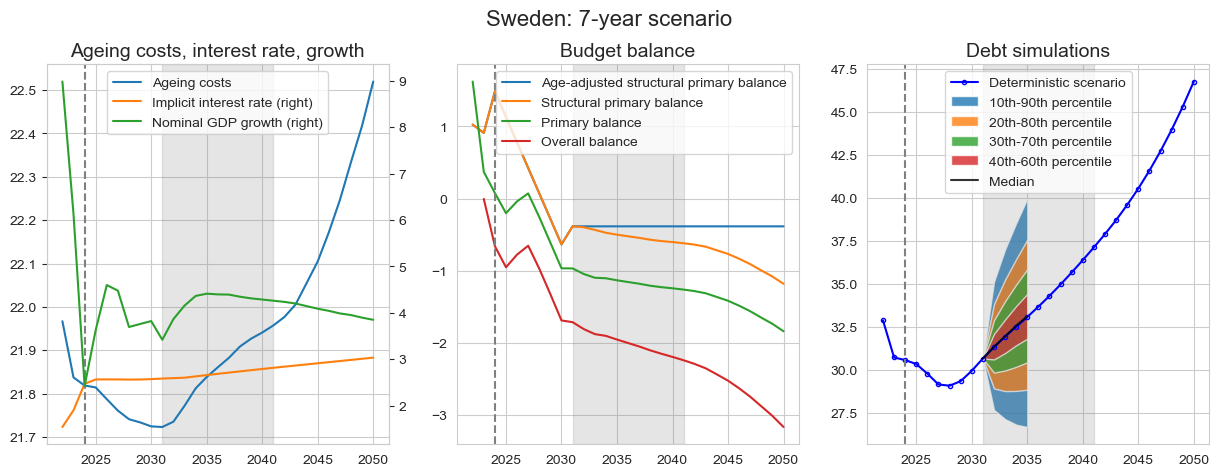

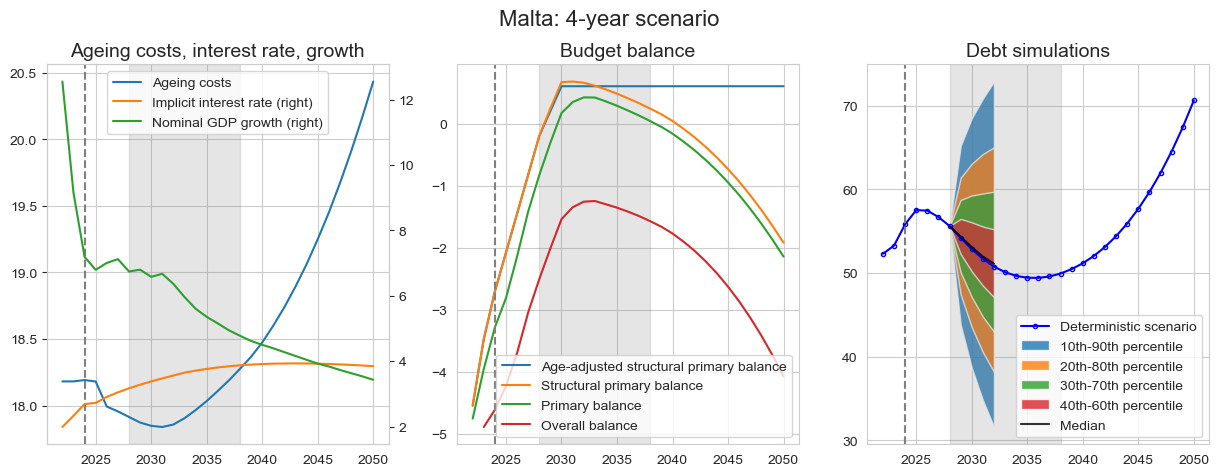

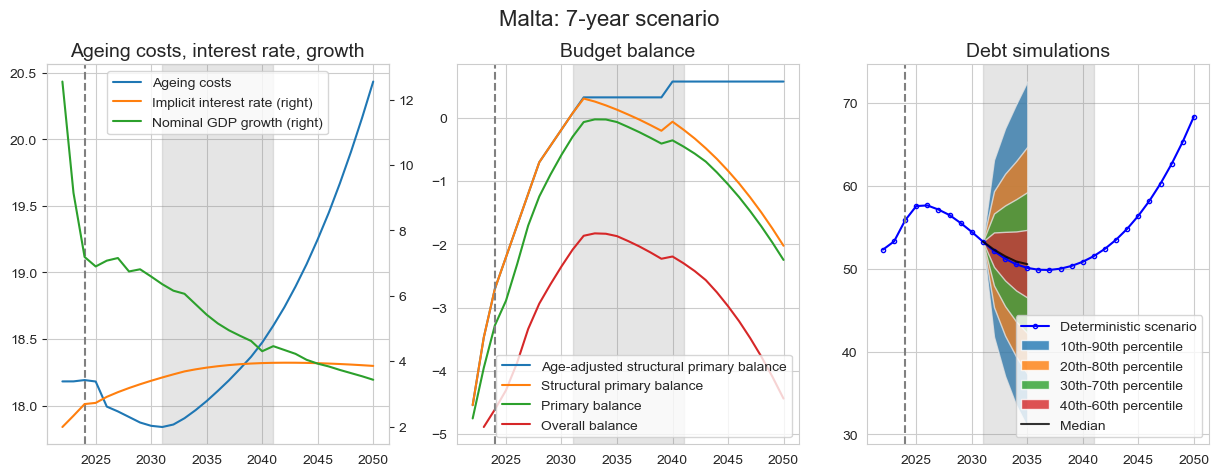

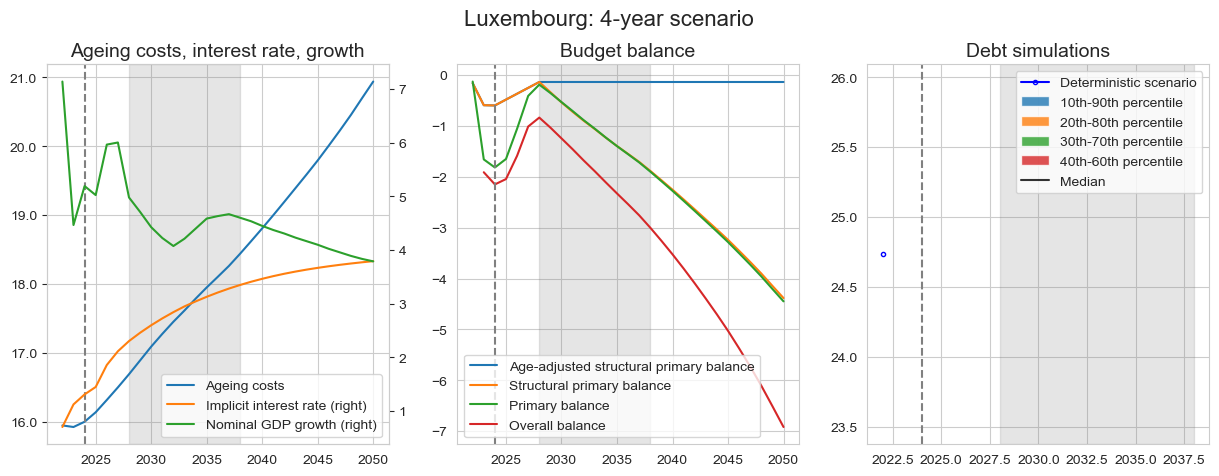

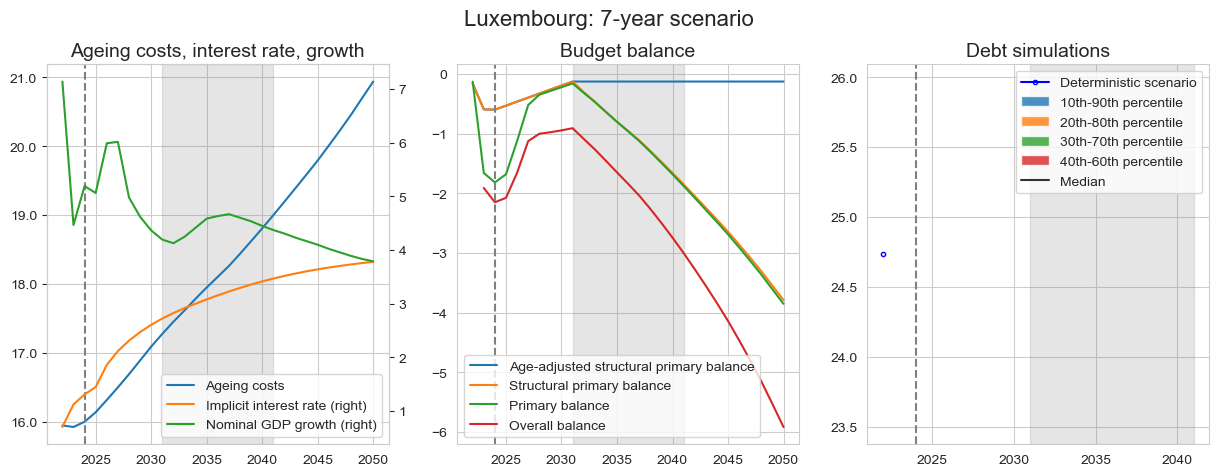

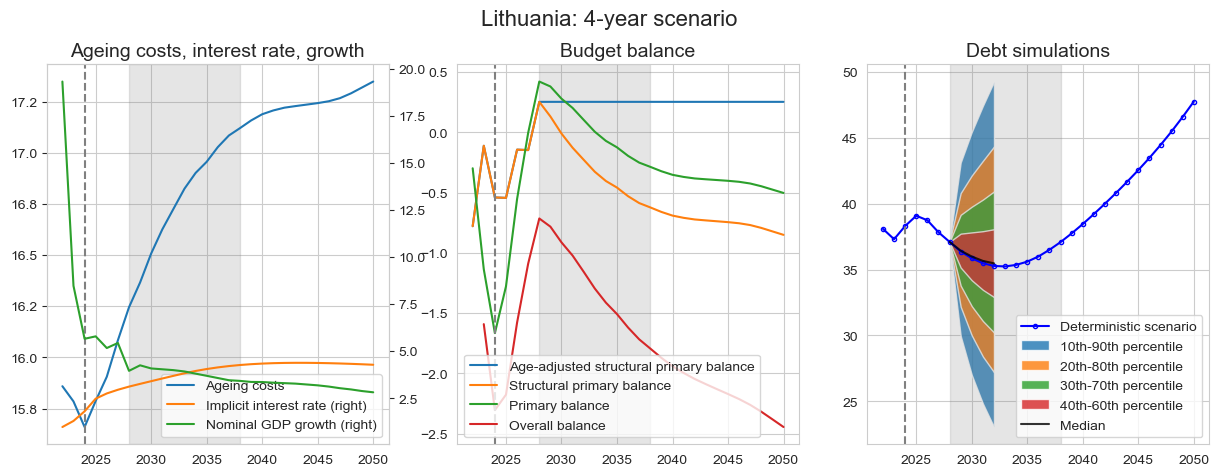

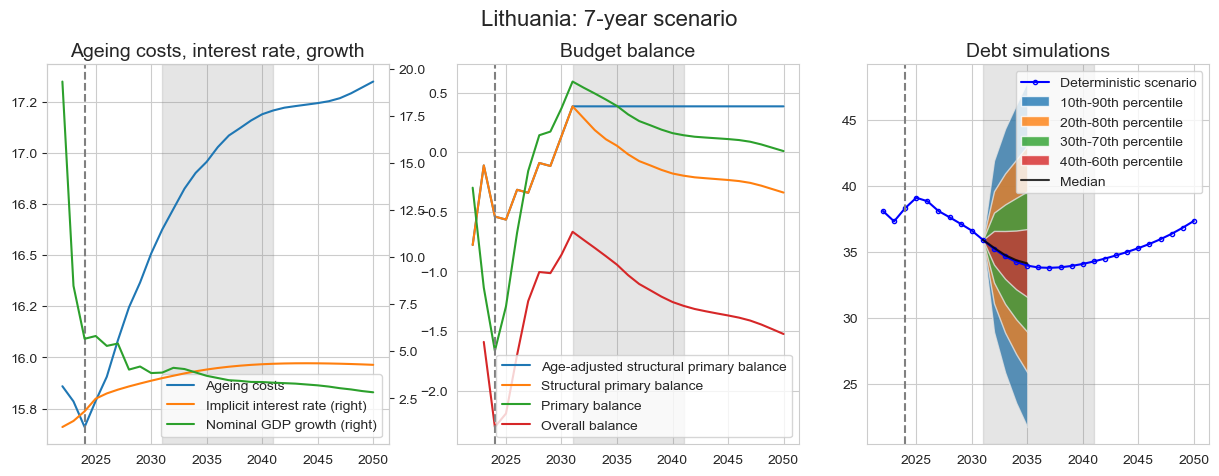

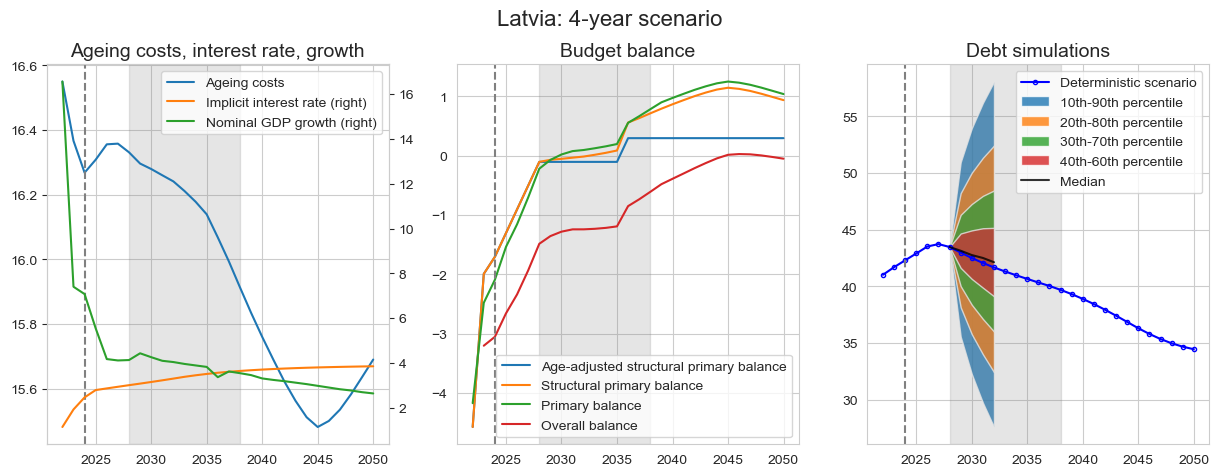

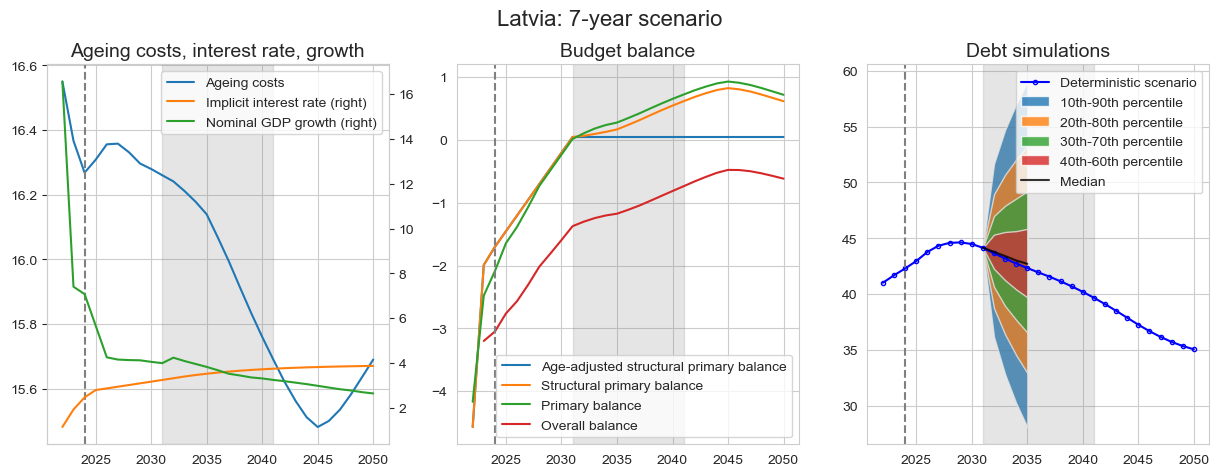

In [43]:
plot_annex_charts(country_code_dict, results_dict, output_path, today)